# IMPORTS

In [95]:

import pandas as pd
import time
from datetime import datetime, date
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype

from collections import OrderedDict


import warnings
warnings.filterwarnings("ignore")

In [96]:
# import ccxt
# exchange = ccxt.binance()
# symbol = 'BTC/USDT'
# ticker_details = exchange.fetchOHLCV(symbol,timeframe='30m')
# # Gets only the last 500 datapoints
# # sample:
# #     [[1647916380000, 41932.94, 41951.09, 41932.49, 41943.61, 97.22523],
# #  [1647916440000, 41943.6, 41961.56, 41866.96, 41896.03, 72.65454],
# #  [1647916500000, 41896.02, 41896.03, 41836.26, 41849.22, 31.54273],
# #  [1647916560000, 41849.21, 41862.51, 41806.79, 41841.26, 57.97157],

# LOAD DATA

In [97]:
# Downloaded data from https://www.cryptodatadownload.com/data/binance/
test_data = pd.read_csv('data/Binance_BTCUSDT_1h.csv')
display(test_data.head())
display(test_data.tail())

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1.647302e+12,2022-03-15 00:00:00,BTC/USDT,39671.37,39804.68,39384.38,39412.30,1176.35199,4.661403e+07,23806.0
1,1.647299e+12,2022-03-14 23:00:00,BTC/USDT,39326.12,39784.25,39326.11,39671.37,2191.13079,8.678891e+07,47474.0
2,1.647295e+12,2022-03-14 22:00:00,BTC/USDT,38729.97,39947.12,38677.68,39326.12,4794.81203,1.888155e+08,104187.0
3,1.647292e+12,2022-03-14 21:00:00,BTC/USDT,38723.35,38787.21,38606.41,38729.97,698.12721,2.703083e+07,24023.0
4,1.647288e+12,2022-03-14 20:00:00,BTC/USDT,38814.18,38940.00,38702.00,38723.35,1015.60887,3.943958e+07,30537.0


,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
40075,1.502957e+09,2017-08-17 08-AM,BTC/USDT,4349.99,4377.85,4333.32,4360.69,0.9499,4139.70,NaN
40076,1.502953e+09,2017-08-17 07-AM,BTC/USDT,4324.35,4349.99,4287.41,4349.99,4.4400,19241.06,NaN
40077,1.502950e+09,2017-08-17 06-AM,BTC/USDT,4315.32,4345.45,4309.37,4324.35,7.2300,31282.31,NaN
40078,1.502946e+09,2017-08-17 05-AM,BTC/USDT,4308.83,4328.69,4291.37,4315.32,23.2300,100304.82,NaN
40079,1.502942e+09,2017-08-17 04-AM,BTC/USDT,16199.91,16199.91,4261.32,4308.83,44.5100,190952.85,NaN


In [98]:
# btc_1h.head()

# CONFIG

In [99]:
FEATURES_COLUMNS = ['open','close', 'Volume BTC']
ANALYSIS_START_DATE = date(2021,1,1) 
ANALYSIS_END_DATE = date(2021,12,31)
TEST_START_DATE = date(2022,1,1)
TEST_END_DATE = date(2022,3,31)
VOLUME_COLUMN = 'Volume BTC'
DAYS_OF_WEEK =["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
WEEKEND_DAYS = ['Saturday','Sunday']
WEEKDAY_DAYS =["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

DAYS_OF_WEEK_CAT = CategoricalDtype(DAYS_OF_WEEK, ordered=True)

INVESTMENT_AMOUNT_DOLLARS = 500

# UTILITY FUNCTIONS

## DATA PREPROCESSING FUNCTIONS

### CORRECT DATETIME

In [100]:
def set_datetime(row):
    try:
        row['actual_date'] = pd.to_datetime(row['date'])
    except:
        row['actual_date'] = pd.to_datetime(row['date'], format='%Y-%m-%d %I-%p')
        
    return row

def set_actual_date(data_df):
    # Set the datetime column
    data_df =  data_df.apply(lambda x: set_datetime(x),axis=1)
    return data_df

### FILTER DATA

In [101]:


def preprocess(scrip_df, start_date, end_date = '2030-01-01'):
    
    # Filter data based on the start and end data
    scrip_df = scrip_df[(scrip_df['actual_date'].dt.date>=start_date) & (scrip_df['actual_date'].dt.date<=end_date)]
    
    # Sort data based on the date
    scrip_df.sort_values(by=['actual_date'], ascending = False, inplace=True)

    # Set date as Index. Keep only the close price.
    scrip_df.set_index('actual_date', drop=True,inplace=True)
    
    
    # Keep only the required columns and drop the rest
    scrip_df = scrip_df[FEATURES_COLUMNS]
    
    return scrip_df

## FEATURE ENGINEERING

### ADD HOUR, DAY OF THE WEEK & WEEK NUMBER

In [102]:

def get_day_of_week(row):
    return DAYS_OF_WEEK[row.name.weekday()]

def get_week(row):
    return row.name.isocalendar().week


def get_hour(row):
    return row.name.time().hour
    
def add_timestamp_features(scrip_df,add_hours=True):

    scrip_df['day'] = scrip_df.apply(lambda x: get_day_of_week(x),axis=1).astype(DAYS_OF_WEEK_CAT)
    scrip_df['week'] = scrip_df.apply(lambda x: get_week(x),axis=1)
    
    if add_hours:
        scrip_df['hour'] = scrip_df.apply(lambda x: get_hour(x),axis=1)
    
    return scrip_df

### ADD PROFIT/LOSS FOR THE CANDLE

In [103]:
def add_profitloss_features(scrip_df):
    scrip_df['closed_green'] = scrip_df['close'] > scrip_df['open']
    scrip_df['closed'] = scrip_df.apply(lambda x: 'GREEN' if (x['close'] >= x['open']) else 'RED',axis=1)
    scrip_df['profit_pct'] = (scrip_df['close'] - scrip_df['open'])/scrip_df['open'] * 100
    return scrip_df

### ADD NEXT CANDLES

In [104]:
def add_next_open_features(scrip_df):
    scrip_df['next2_open'] = scrip_df['open'].shift(2)
    scrip_df['next2_opened'] = scrip_df.apply(lambda x: 'GREEN' if (x['next2_open'] >= x['open']) else 'RED',axis=1)
    
    
    scrip_df['next3_open'] = scrip_df['open'].shift(3)
    scrip_df['next3_opened'] = scrip_df.apply(lambda x: 'GREEN' if (x['next3_open'] >= x['open']) else 'RED',axis=1)
    
    # 4-hour window
    scrip_df['next4_open'] = scrip_df['open'].shift(4)
    scrip_df['next4_opened'] = scrip_df.apply(lambda x: 'GREEN' if (x['next4_open'] >= x['open']) else 'RED',axis=1)
    
    # 6-hour window
    scrip_df['next6_open'] = scrip_df['open'].shift(6)
    scrip_df['next6_opened'] = scrip_df.apply(lambda x: 'GREEN' if (x['next6_open'] >= x['open']) else 'RED',axis=1)
    
    # 8-hour window
    scrip_df['next8_open'] = scrip_df['open'].shift(8)
    scrip_df['next8_opened'] = scrip_df.apply(lambda x: 'GREEN' if (x['next8_open'] >= x['open']) else 'RED',axis=1)
    
    # 12-hour window
    scrip_df['next12_open'] = scrip_df['open'].shift(12)
    scrip_df['next12_opened'] = scrip_df.apply(lambda x: 'GREEN' if (x['next12_open'] >= x['open']) else 'RED',axis=1)
    
    # 24-hour window
    scrip_df['next24_open'] = scrip_df['open'].shift(24)
    scrip_df['next24_opened'] = scrip_df.apply(lambda x: 'GREEN' if (x['next24_open'] >= x['open']) else 'RED',axis=1)
    
    # 48-hour window
    scrip_df['next48_open'] = scrip_df['open'].shift(48)
    scrip_df['next48_opened'] = scrip_df.apply(lambda x: 'GREEN' if (x['next48_open'] >= x['open']) else 'RED',axis=1)
    
    return scrip_df



## FIND PATTERNS

### PATTERN BASED ON WINDOW PERIOD

In [105]:
def get_grouped_data(scrip_df, closed_col, groupbyday):
    group_cols = ['day','hour',closed_col] if groupbyday else ['hour',closed_col] 
    return pd.DataFrame(scrip_df.groupby(group_cols).size().reset_index())
    
def get_window_range(hr, window_period):
    end_time = f'-{(hr+window_period)%24}:00' if window_period < 24 \
        else f'+{int(window_period/24)}d' 
    return f'{hr}:00{end_time}'
    
def get_pattern_for_window(scrip_df, groupbyday = True, window_period = 1): #closed_col = 'closed'):
    closed_col = 'closed' if (window_period == 1) else f'next{window_period}_opened'
    closed_df = get_grouped_data(scrip_df,  closed_col, groupbyday)
    closed_df.rename(columns = {0:'count'},inplace = True)    
    merge_cols = ['day','hour'] if groupbyday else ['hour']

    closed_total = pd.DataFrame(scrip_df.groupby(merge_cols).size().reset_index())
    #closed_total.rename(columns = {0:'total',closed_col:'profit_or_loss'},inplace = True)
    closed_df = pd.merge(closed_df, closed_total, how='left', on=merge_cols)
    
    closed_df.rename(columns = {0:'total',closed_col:'profit_or_loss'},inplace = True)
    
    
    closed_df['hours'] = closed_df['hour'].apply(lambda x: get_window_range(x, window_period))
        
    closed_df['percent'] = round(closed_df['count']/closed_df['total']*100,2)
    closed_df.sort_values('percent',ascending=False, inplace=True)
    
    final_cols = ['day','hours','profit_or_loss','percent'] if groupbyday else ['hours','profit_or_loss','percent']
    return closed_df[final_cols]
   


## PLOTS

### PLOT BAR CHART

In [106]:
def plot_data_bar(chart_df,y_col, title_string, x_label, y_label, palette_type = 'hls', 
                  show_yvalue = False, ylimmax = None, xticks_rotate = None):
    f, ax = plt.subplots(figsize=(16,8))
    ax = sns.barplot(x=chart_df.index, y=chart_df[y_col],palette = palette_type)
    ax.set( xlabel=x_label,ylabel=y_label,title = title_string)
    
    if ylimmax is not None:
        plt.ylim(ymax = ylimmax)
    
    if xticks_rotate is not None:
        plt.xticks(rotation=xticks_rotate, ha='right')
        
        
    if show_yvalue:
        
        for i in ax.containers:
            ax.bar_label(i,)
            
            
    plt.show()

### PLOT THE BEST TIME TO TRADE BAR CHART

In [107]:
# best_window_data

In [108]:
# best_window_data = hourly3_pattern.sort_values(['percent','profit_or_loss'], ascending=False) \
#                            .drop_duplicates(['day','profit_or_loss']) 

# best_window_data = best_window_data.sort_values(['day','profit_or_loss']).reset_index(drop=True)
# plot_best_time_window(best_window_data,'TEST')


In [109]:
# #ax = sns.barplot(x="day", y="percent", hue="profit_or_loss", data=best_window_df,palette = {'RED': "red", 'GREEN': "forestgreen"})
# patches_dict = {}
# for i, p in enumerate(ax.patches):
#     patches_dict[p.get_x()] = p
    

# from collections import OrderedDict
# sorted_patches = OrderedDict(sorted(patches_dict.items()))


# print(sorted_patches)


In [110]:
def plot_best_time_window(best_window_df, title_string):
    sns.set(style="white", context="talk")
    f, ax = plt.subplots(figsize=(16,10))
    #limegreen,lightseagreen,darkgreen, seagreen,forestgreen, mediumseagreen
    # https://medium.com/@andykashyap/top-5-tricks-to-make-plots-look-better-9f6e687c1e08
    hue_colors = {'RED': "red", 'GREEN': "forestgreen"}
    ax = sns.barplot(x="day", y="percent", hue="profit_or_loss", data=best_window_df,palette = hue_colors)
    ax.set( xlabel='Day',ylabel='Percentage',title = f'BEST TIME TO TRADE - {title_string}')
    #plt.legend(title = "Profit/Loss")
    plt.ylim(ymax = 100, ymin = 0)
    plt.legend().remove()

#     for i, p in enumerate(ax.patches):
#         print(i)
#         print(p)

#         ax.text(p.get_x()+p.get_width()/2., p.get_height() + 1, 
#                 f"{int(best_window_df.loc[i]['percent'])}%",ha="center")
#         ax.text(p.get_x()+p.get_width()/2., p.get_height() + 8, 
#                 f"{best_window_df.loc[i]['hours']}",ha="center", rotation=90)
#         print(f"{int(best_window_df.loc[i]['percent'])}%")
 
    # Sort patches based on the rectangle's x value 
    # (patches are not in order by default and labels don't match otherwise)
    patches_dict = {}
    for i, p in enumerate(ax.patches):
        patches_dict[p.get_x()] = p
    sorted_patches = OrderedDict(sorted(patches_dict.items()))
    i = 0
    for px, p in sorted_patches.items():
        ax.text(p.get_x()+p.get_width()/2., p.get_height() + 1, 
                f"{int(best_window_df.loc[i]['percent'])}%",ha="center")
        ax.text(p.get_x()+p.get_width()/2., p.get_height() + 8, 
                f"{best_window_df.loc[i]['hours']}",ha="center", rotation=90)
        i += 1

    
    
    plt.show()
     

def display_window_pattern(pattern_df, title_string):
    best_window_data = pattern_df.sort_values(['percent','profit_or_loss'], ascending=False) \
                               .drop_duplicates(['day','profit_or_loss']) 
    
    best_window_data = best_window_data.sort_values(['day','profit_or_loss']).reset_index(drop=True)
    #best_window_data = best_window_data.set_index('day',drop=False).loc[DAYS_OF_WEEK]                  
    plot_best_time_window(best_window_data,title_string)
    return best_window_data
    
#display_window_pattern(hourly3_pattern,"THREE HOURS WINDOW")    


# HOURLY DATA ANALYSIS

## LOAD THE DATA

In [111]:
complete_1h_df = pd.read_csv('data/Binance_BTCUSDT_1h.csv')
complete_1h_df = set_actual_date(complete_1h_df)

print(f'Shape - initial:{complete_1h_df.shape}')
scrip_1h_df = preprocess(complete_1h_df, ANALYSIS_START_DATE, ANALYSIS_END_DATE)
print(f'Shape - after preprocess:{scrip_1h_df.shape}')
scrip_1h_df = add_timestamp_features(scrip_1h_df)
scrip_1h_df = add_profitloss_features(scrip_1h_df)
scrip_1h_df = add_next_open_features(scrip_1h_df)

print(f'Shape - after adding features:{scrip_1h_df.shape}')
display(scrip_1h_df.head())
display(scrip_1h_df.tail())

Shape - initial:(40080, 11)
Shape - after preprocess:(8747, 3)
Shape - after adding features:(8747, 25)


,open,close,Volume BTC,day,week,hour,closed_green,closed,profit_pct,next2_open,...,next6_open,next6_opened,next8_open,next8_opened,next12_open,next12_opened,next24_open,next24_opened,next48_open,next48_opened
actual_date,,,,,,,,,,,,,,,,,,,,,
2021-12-31 23:00:00,46303.98,46216.93,985.99762,Thursday,52,23,False,RED,-0.187997,NaN,...,NaN,RED,NaN,RED,NaN,RED,NaN,RED,NaN,RED
2021-12-31 22:00:00,46333.87,46303.99,991.85142,Thursday,52,22,False,RED,-0.064488,NaN,...,NaN,RED,NaN,RED,NaN,RED,NaN,RED,NaN,RED
2021-12-31 21:00:00,45886.66,46333.86,1734.69585,Thursday,52,21,True,GREEN,0.974575,46303.98,...,NaN,RED,NaN,RED,NaN,RED,NaN,RED,NaN,RED
2021-12-31 20:00:00,45728.28,45879.24,1831.41202,Thursday,52,20,True,GREEN,0.330124,46333.87,...,NaN,RED,NaN,RED,NaN,RED,NaN,RED,NaN,RED
2021-12-31 19:00:00,46686.42,45728.28,3851.30902,Thursday,52,19,False,RED,-2.052288,45886.66,...,NaN,RED,NaN,RED,NaN,RED,NaN,RED,NaN,RED


,open,close,Volume BTC,day,week,hour,closed_green,closed,profit_pct,next2_open,...,next6_open,next6_opened,next8_open,next8_opened,next12_open,next12_opened,next24_open,next24_opened,next48_open,next48_opened
actual_date,,,,,,,,,,,,,,,,,,,,,
2021-01-01 04:00:00,29278.41,29220.31,2038.046803,Thursday,53,4,False,RED,-0.198440,29187.01,...,29202.21,RED,29313.49,GREEN,29188.67,RED,29351.95,GREEN,32576.11,GREEN
2021-01-01 03:00:00,29195.25,29278.40,1461.345077,Thursday,53,3,True,GREEN,0.284807,29220.31,...,29000.01,RED,29223.82,GREEN,29327.83,GREEN,29323.82,GREEN,32741.68,GREEN
2021-01-01 02:00:00,29410.00,29194.65,2384.231560,Thursday,53,2,False,RED,-0.732234,29278.41,...,29092.84,RED,29202.21,RED,29464.79,GREEN,29359.46,RED,32583.04,GREEN
2021-01-01 01:00:00,28995.13,29409.99,5403.068471,Thursday,53,1,True,GREEN,1.430792,29195.25,...,29174.35,GREEN,29000.01,GREEN,29233.49,GREEN,29197.93,GREEN,32447.95,GREEN
2021-01-01 00:00:00,28923.63,28995.13,2311.811445,Thursday,53,0,True,GREEN,0.247203,29410.00,...,29187.01,GREEN,29092.84,GREEN,29313.49,GREEN,29331.70,GREEN,32176.45,GREEN


## ANALYSIS

### AVERAGE HOURLY VOLUME TRADED

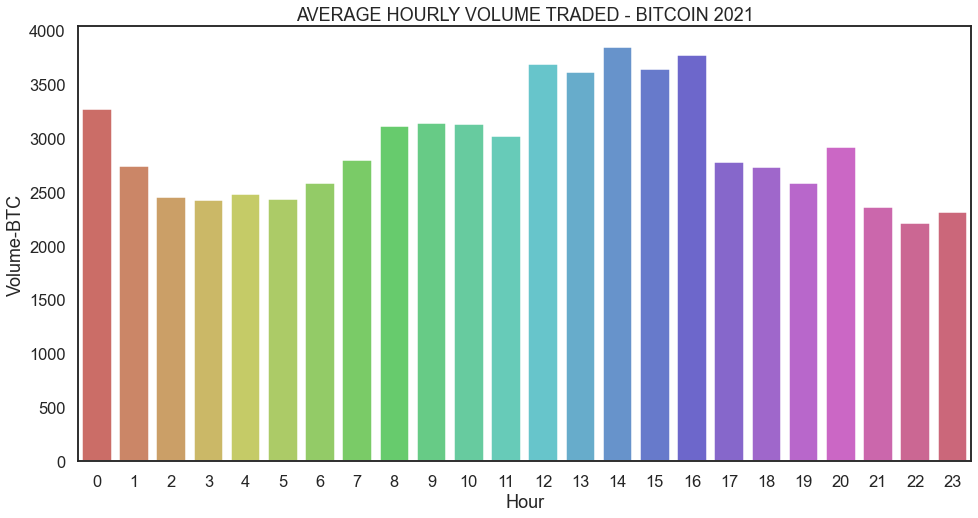

In [112]:
avg_hourly_trade = pd.DataFrame(scrip_1h_df.groupby(['hour'])[VOLUME_COLUMN].mean().sort_values(ascending=False))
avg_hourly_trade.sort_index(inplace=True)
plot_data_bar(avg_hourly_trade,VOLUME_COLUMN,'AVERAGE HOURLY VOLUME TRADED - BITCOIN 2021','Hour','Volume-BTC')

### AVERAGE DAILY VOLUME TRADED

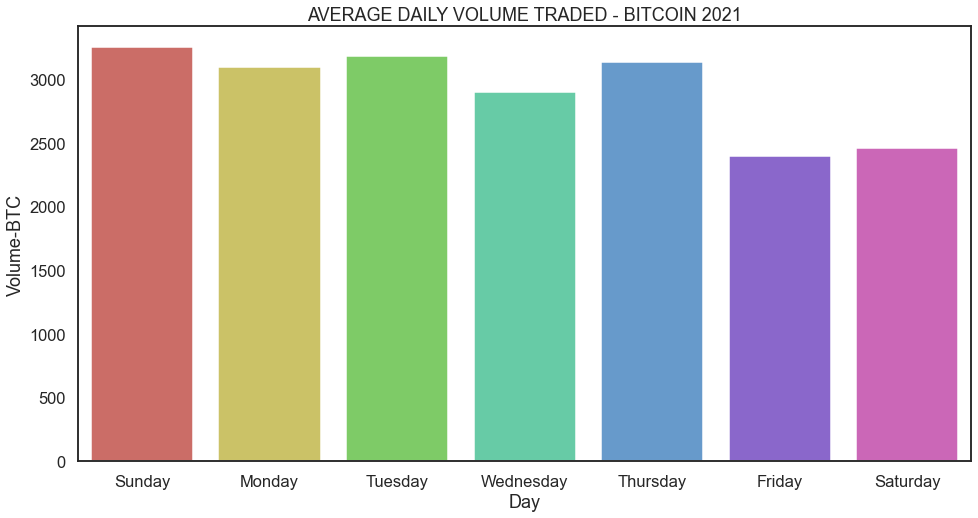

In [113]:
avg_weekly_trade = pd.DataFrame(scrip_1h_df.groupby(['day'])[VOLUME_COLUMN].mean().sort_values(ascending=False))
plot_data_bar(avg_weekly_trade.loc[DAYS_OF_WEEK],VOLUME_COLUMN,'AVERAGE DAILY VOLUME TRADED - BITCOIN 2021','Day','Volume-BTC')


### AVERAGE HOURLY VOLUME TRADED ON WEEKENDS

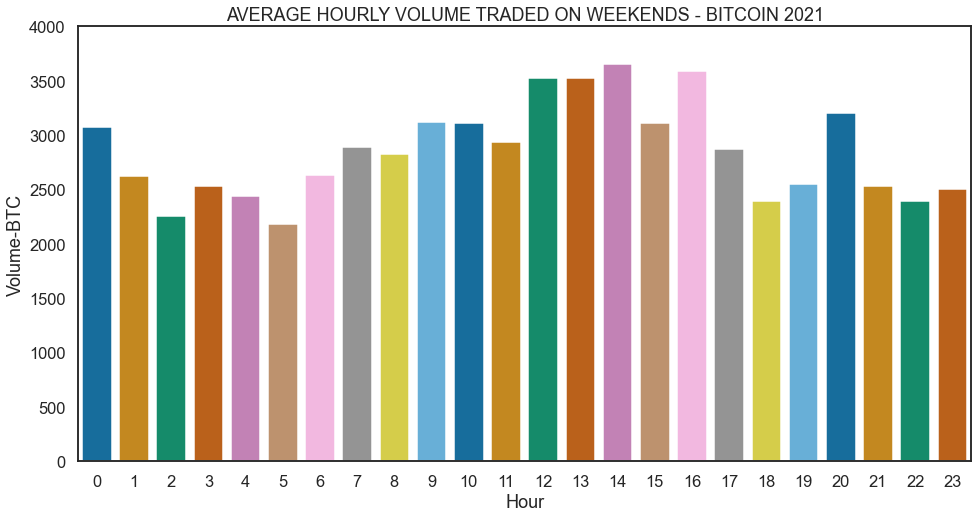

In [114]:
avg_weekend_hourly_trade = pd.DataFrame(scrip_1h_df[scrip_1h_df['day'].isin(WEEKEND_DAYS)].groupby(['hour'])[VOLUME_COLUMN].mean().sort_values(ascending=False))
avg_weekend_hourly_trade.sort_index(inplace=True)
plot_data_bar(avg_weekend_hourly_trade,VOLUME_COLUMN,'AVERAGE HOURLY VOLUME TRADED ON WEEKENDS - BITCOIN 2021','Hour','Volume-BTC',
             palette_type = 'colorblind',ylimmax = 4000)


### AVERAGE HOURLY VOLUME TRADED ON WEEKDAYS

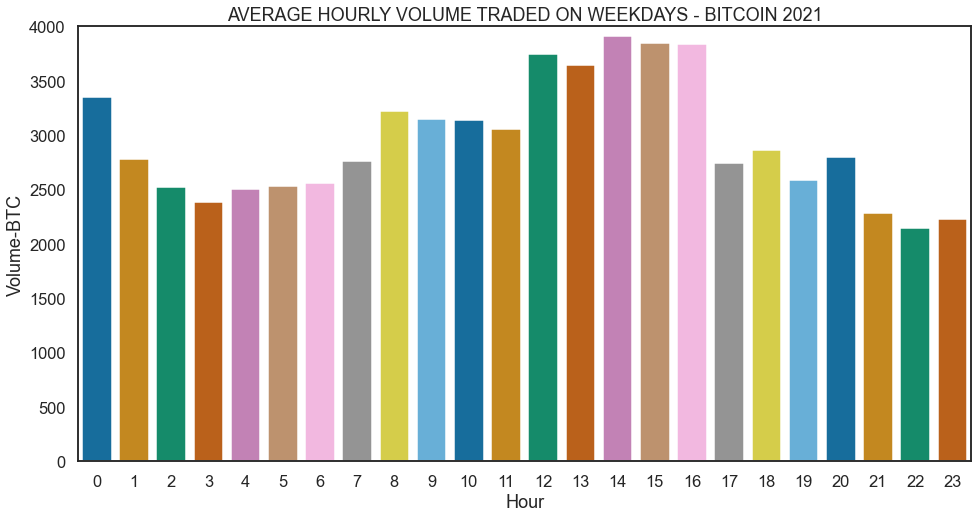

In [115]:
avg_weekdays_hourly_trade = pd.DataFrame(scrip_1h_df[scrip_1h_df['day'].isin(WEEKDAY_DAYS)].groupby(['hour'])[VOLUME_COLUMN].mean().sort_values(ascending=False))
avg_weekdays_hourly_trade.sort_index(inplace=True)
plot_data_bar(avg_weekdays_hourly_trade,VOLUME_COLUMN,'AVERAGE HOURLY VOLUME TRADED ON WEEKDAYS - BITCOIN 2021','Hour','Volume-BTC',
             palette_type = 'colorblind',ylimmax = 4000)




### BEST DAILY TRADING TIME

#### HOURLY WINDOW

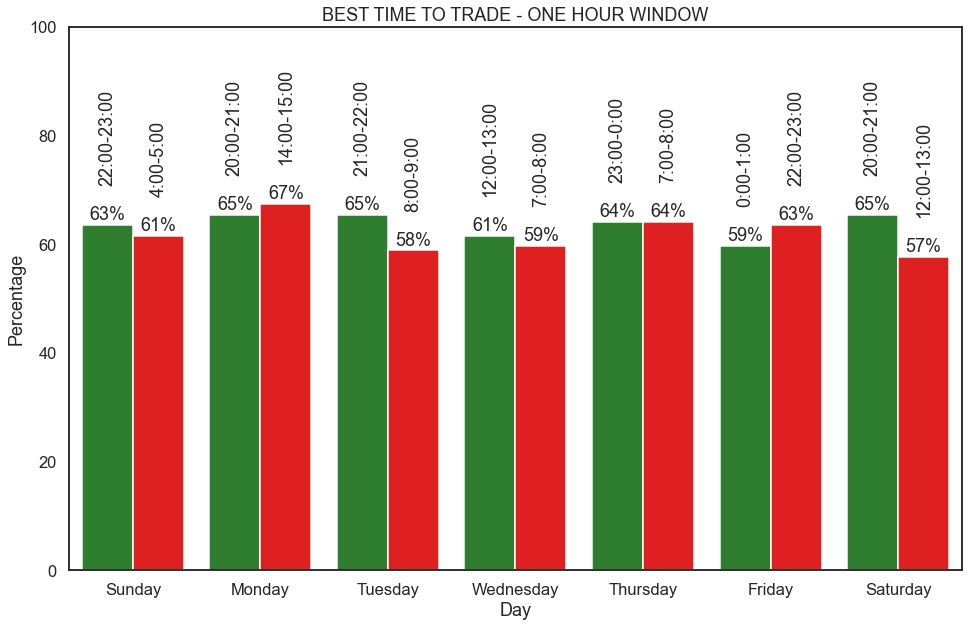

In [116]:
hourly_pattern = get_pattern_for_window(scrip_1h_df,  groupbyday = True, window_period = 1)
best_hourly_pattern = display_window_pattern(hourly_pattern,"ONE HOUR WINDOW")

#### TWO-HOURS WINDOW

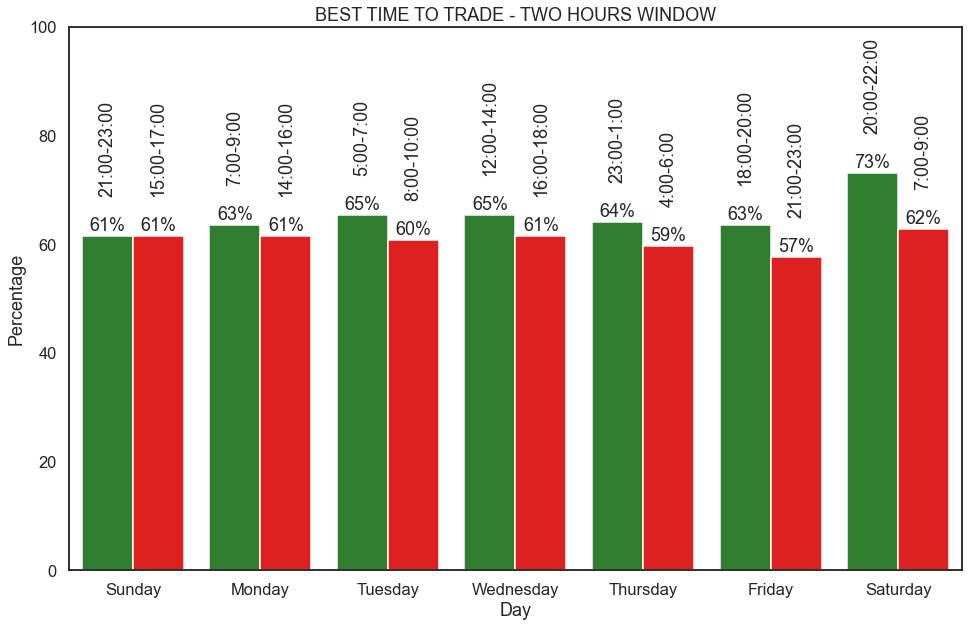

In [117]:
hourly2_pattern = get_pattern_for_window(scrip_1h_df,  groupbyday = True, window_period = 2)
best_hourly2_pattern = display_window_pattern(hourly2_pattern,"TWO HOURS WINDOW")

#### THREE-HOURS WINDOW

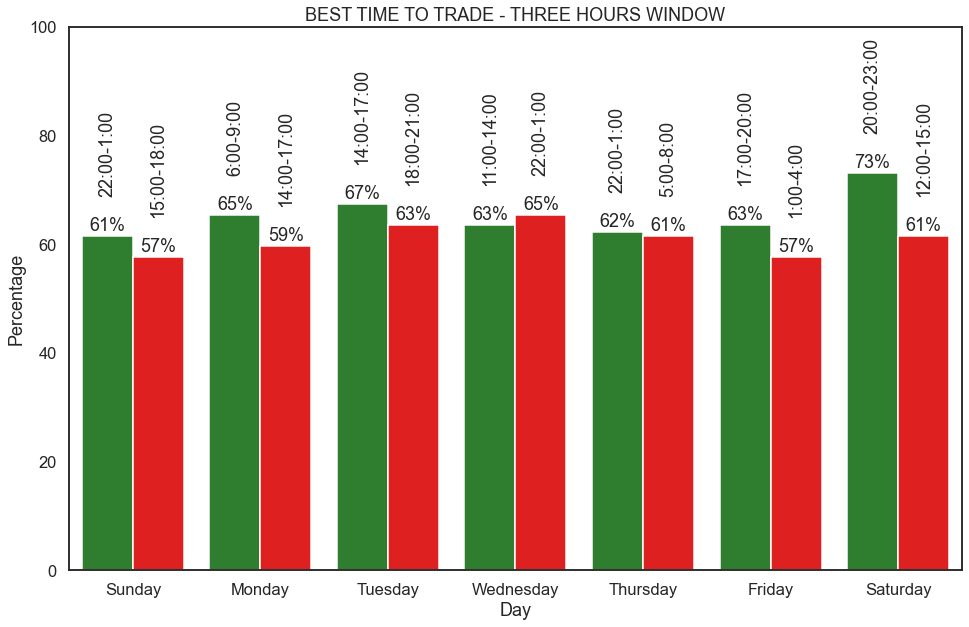

In [118]:
hourly3_pattern = get_pattern_for_window(scrip_1h_df,  groupbyday = True, window_period = 3)
best_hourly3_pattern = display_window_pattern(hourly3_pattern,"THREE HOURS WINDOW")

#### FOUR-HOURS WINDOW

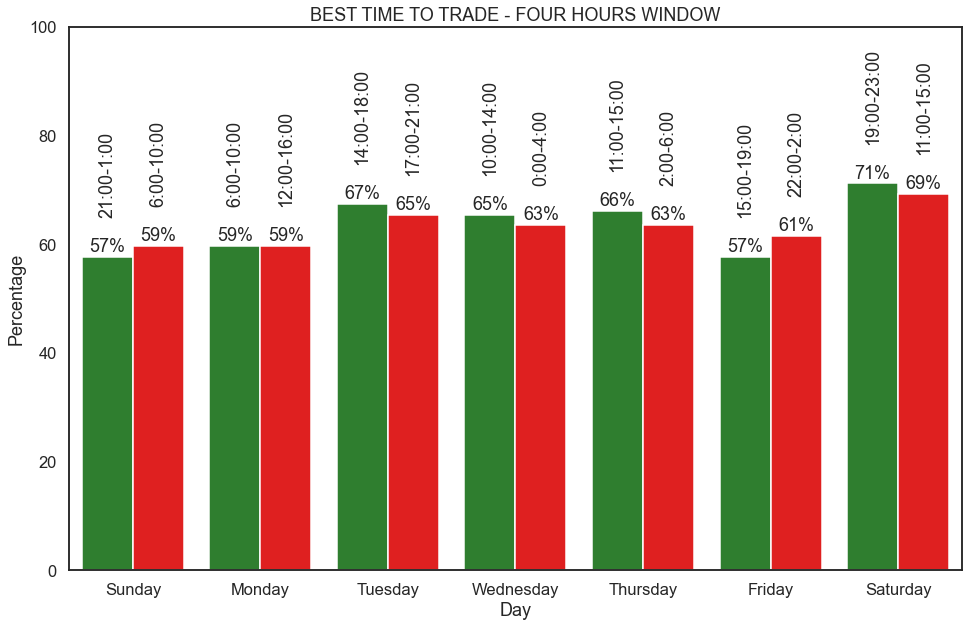

In [119]:
hourly4_pattern = get_pattern_for_window(scrip_1h_df,  groupbyday = True, window_period = 4)
best_hourly4_pattern = display_window_pattern(hourly4_pattern,"FOUR HOURS WINDOW")

#### SIX-HOURS WINDOW

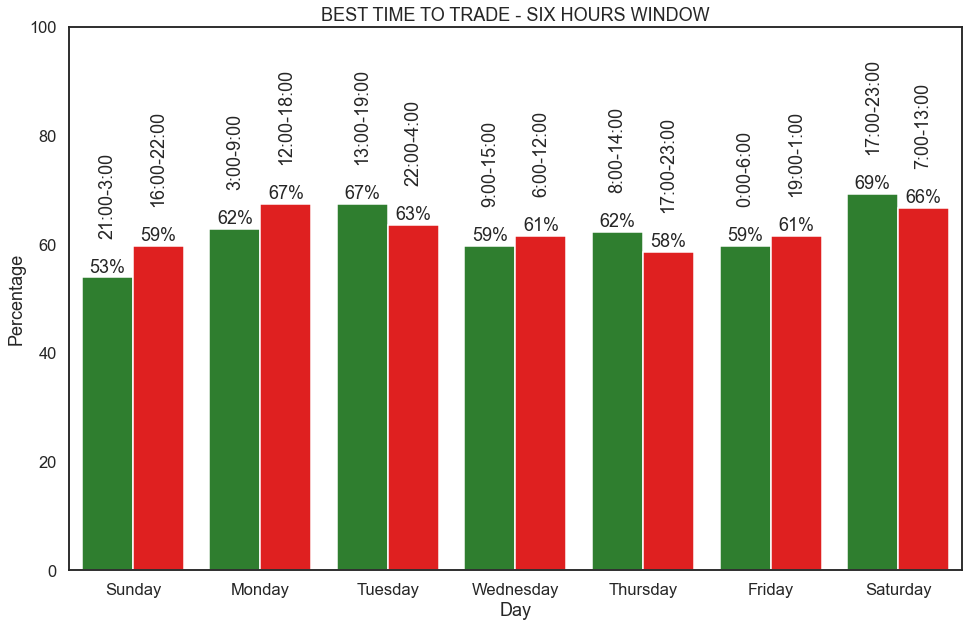

In [120]:
hourly6_pattern = get_pattern_for_window(scrip_1h_df,  groupbyday = True, window_period = 6)
best_hourly6_pattern = display_window_pattern(hourly6_pattern,"SIX HOURS WINDOW")

#### EIGHT-HOURS WINDOW

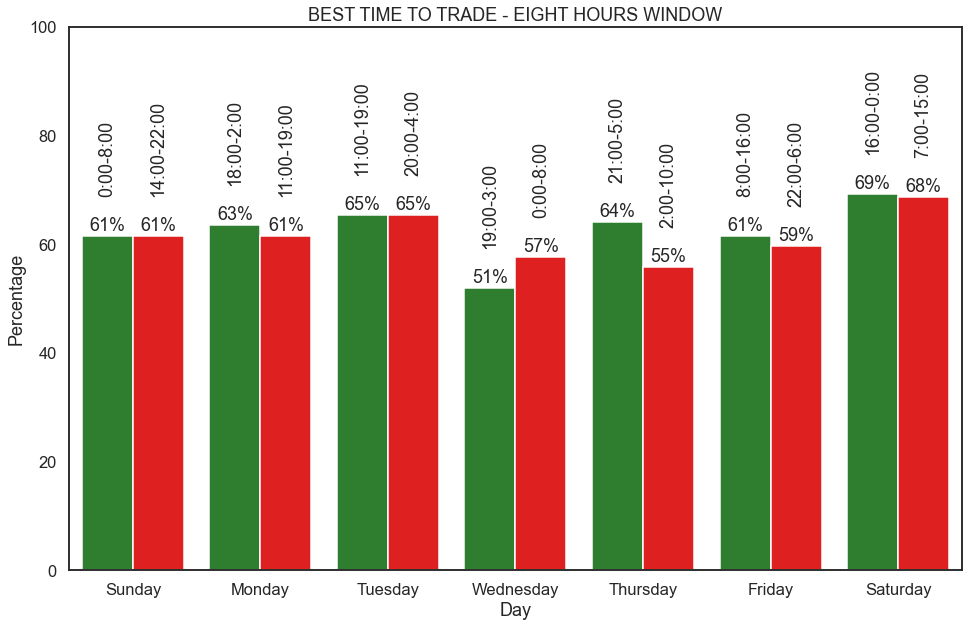

In [121]:
hourly8_pattern = get_pattern_for_window(scrip_1h_df,  groupbyday = True, window_period = 8)
best_hourly8_pattern = display_window_pattern(hourly8_pattern,"EIGHT HOURS WINDOW")

#### TWELVE-HOURS WINDOW

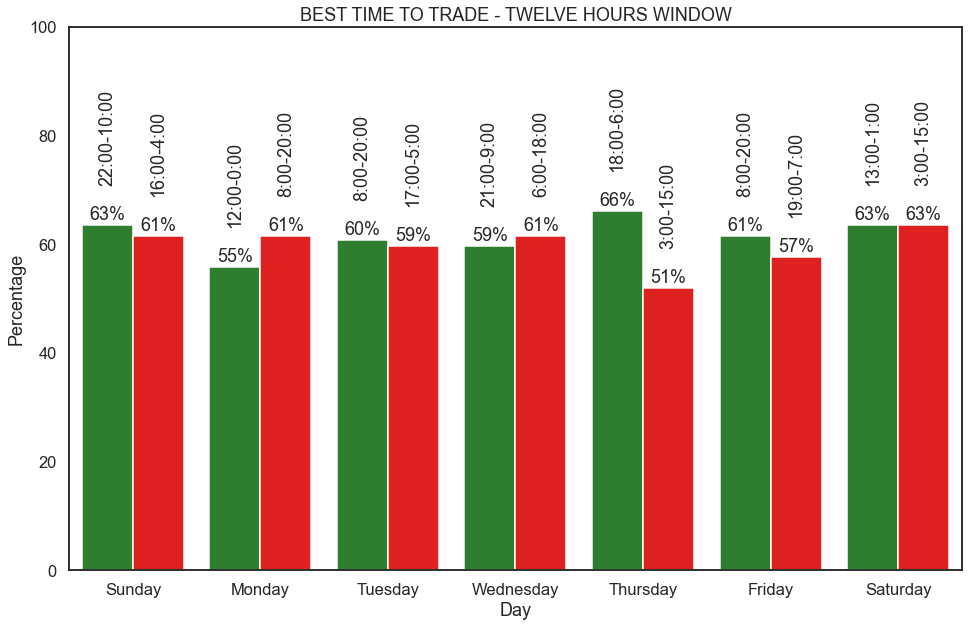

In [122]:
hourly12_pattern = get_pattern_for_window(scrip_1h_df,  groupbyday = True, window_period = 12)
best_hourly12_pattern = display_window_pattern(hourly12_pattern,"TWELVE HOURS WINDOW")

#### 1-DAY WINDOW

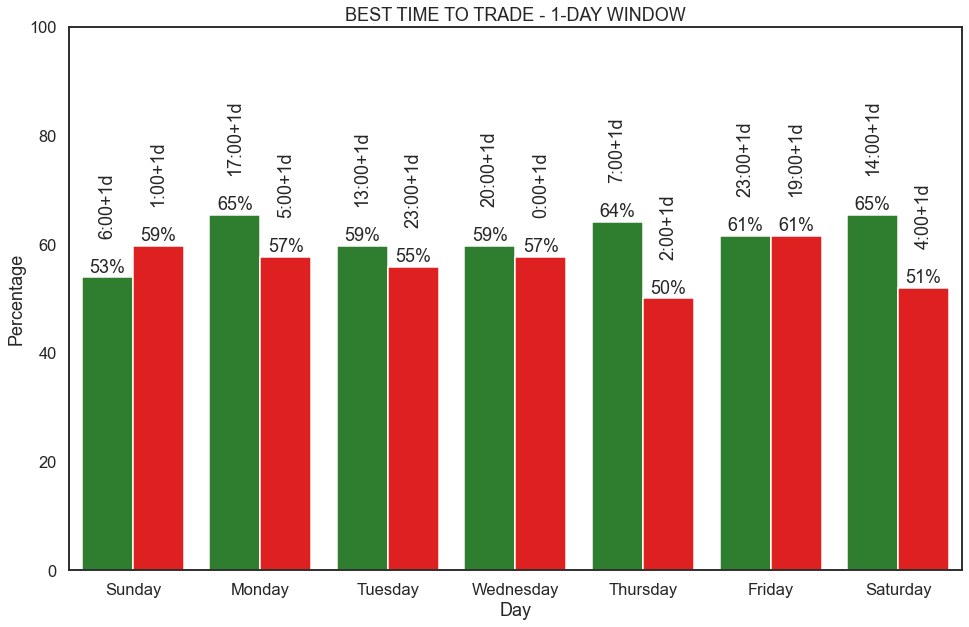

In [123]:
hourly24_pattern = get_pattern_for_window(scrip_1h_df,  groupbyday = True, window_period = 24)
best_hourly24_pattern = display_window_pattern(hourly24_pattern,"1-DAY WINDOW")

#### 2-DAYS WINDOW

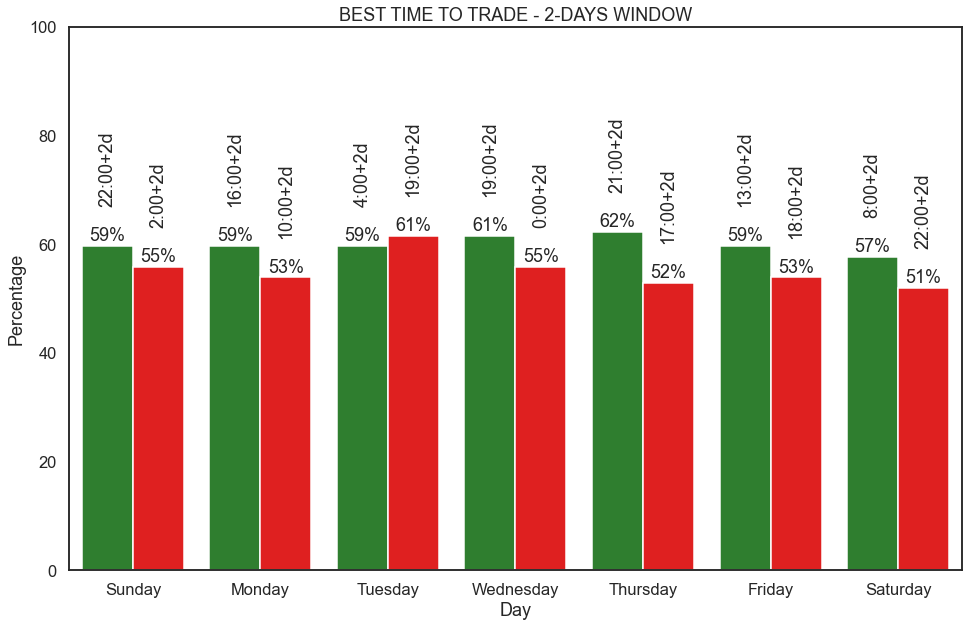

In [124]:
hourly48_pattern = get_pattern_for_window(scrip_1h_df,  groupbyday = True, window_period = 48)
best_hourly48_pattern = display_window_pattern(hourly48_pattern,"2-DAYS WINDOW")

### BEST TRADING TIME FOR A DAY

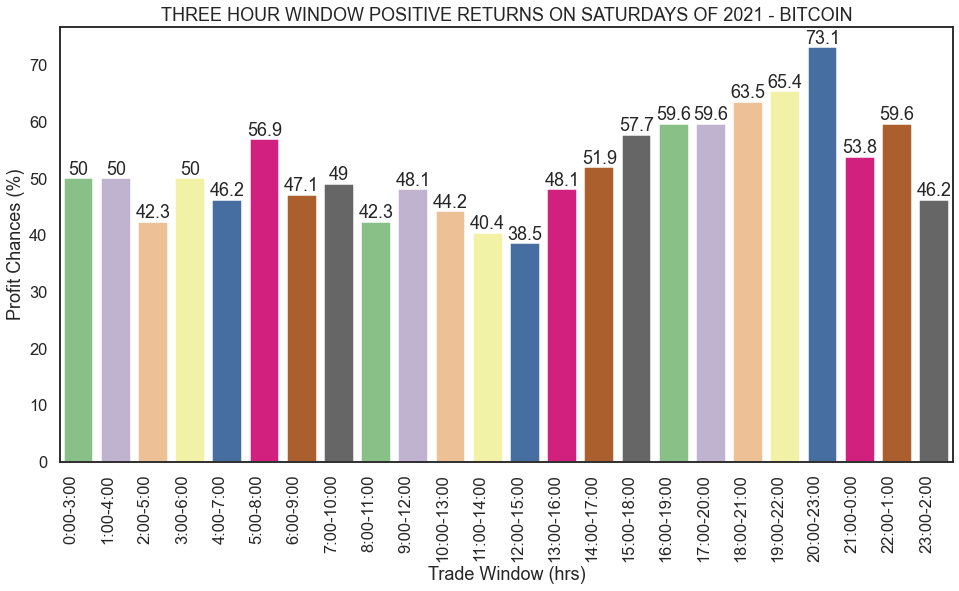

,profit_or_loss,percent,hour
hours,,,
0:00-3:00,GREEN,50.0,0
1:00-4:00,GREEN,50.0,1
2:00-5:00,GREEN,42.3,2
3:00-6:00,GREEN,50.0,3
4:00-7:00,GREEN,46.2,4
5:00-8:00,GREEN,56.9,5
6:00-9:00,GREEN,47.1,6
7:00-10:00,GREEN,49.0,7
8:00-11:00,GREEN,42.3,8


In [125]:
TRADING_DAY = 'Saturday'
day_scrip_df = scrip_1h_df[scrip_1h_df['day'] == TRADING_DAY]

sat_hourly3_pattern = get_pattern_for_window(day_scrip_df,  groupbyday = False, window_period = 3)

sat_hourly3_pattern['hour'] = sat_hourly3_pattern['hours'].str.split(':',n=-1, expand=True)[0]
sat_hourly3_pattern['hour'] = sat_hourly3_pattern['hour'].astype(int)
sat_hourly3_pattern = sat_hourly3_pattern[sat_hourly3_pattern['profit_or_loss'] == 'GREEN']
sat_hourly3_pattern = sat_hourly3_pattern.sort_values('hour').set_index('hours')
sat_hourly3_pattern['percent'] = round(sat_hourly3_pattern['percent'] ,1)


plot_data_bar(sat_hourly3_pattern,'percent',
              'THREE HOUR WINDOW POSITIVE RETURNS ON SATURDAYS OF 2021 - BITCOIN',
              'Trade Window (hrs)','Profit Chances (%)',
              palette_type = 'Accent',
             show_yvalue = True, xticks_rotate = 90)


sat_hourly3_pattern


# best_sat_hourly3_pattern = display_window_pattern(sat_hourly3_pattern,"SATURDAY - 3 HOURS WINDOW",groupbyday = False)

## TEST RESULTS

### TEST CONFIG

### PREPROCESS TEST DATA

In [126]:
test_df = preprocess(complete_1h_df, TEST_START_DATE, TEST_END_DATE)
test_df = add_timestamp_features(test_df)

### TRADE ONCE IN A WEEK BASED ON BEST CHANCES

In [149]:
def get_test_detailed_trade_df(test_data, window_period, best_timing_df, min_percent = 0):
    test_data['window_price'] = test_data['open'].shift(window_period)
    test_data.reset_index(inplace=True)
    test_data = test_data[(test_data['window_price'].notna())]
    
    best_timing_df = best_timing_df[best_timing_df['profit_or_loss'] == 'GREEN']
    best_timing_df['hour'] = best_timing_df['hours'].str.split(':',n=-1, expand=True)[0]
    best_timing_df['hour'] = best_timing_df['hour'].astype(int)
    # Filter based on minimum percentage of GREENs to consider the trade timing
    best_timing_df = best_timing_df[best_timing_df['percent'] > min_percent]
    
#     print(f'DAILY BEST TIMINGS FOR {window_period} HOURS WINDOW')
#     display(best_timing_df)
    test_filtered_df = pd.merge(best_timing_df, test_data, on=['day','hour'], how='left')

    test_filtered_df['qty'] = INVESTMENT_AMOUNT_DOLLARS/test_filtered_df['open']
    test_filtered_df['profit_loss'] = test_filtered_df['qty'] * test_filtered_df['window_price'] - INVESTMENT_AMOUNT_DOLLARS
    
    if window_period == 3:
        
        print(f'DAILY BEST TIMINGS FOR {window_period} HOURS WINDOW')
        display(best_timing_df[['day','hours','percent']])
        pl_df = pd.DataFrame(test_filtered_df.groupby('day')['profit_loss'].sum())
        pl_df.reset_index(inplace=True)
        display(pl_df)
        test_data.to_csv("test_data_3.csv")
        test_filtered_df.to_csv("test_filtered_3.csv")
        
    return test_filtered_df
    

def get_test_profit_loss(test_data, window_period, best_timing_df, min_percent = 0):
    test_filtered_df = get_test_detailed_trade_df(test_data, window_period, best_timing_df,min_percent)
    profit_loss = round(test_filtered_df['profit_loss'].sum(),2)
    return profit_loss
   # print(f"PROFIT/LOSS - {window_period} hours window:{profit_loss}$ --> {round(profit_loss/INVESTMENT_AMOUNT_DOLLARS*100,2)}%")
    

In [150]:
# TEST_WINDOW_PERIOD = 3
# detailed_pl = get_test_detailed_trade_df(test_df.copy(), TEST_WINDOW_PERIOD, 
#                                          best_hourly_patterns[TEST_WINDOW_PERIOD])
# daily_pl = pd.DataFrame(round(detailed_pl.groupby('day')['profit_loss'].sum(),2))

# plot_data_bar(daily_pl,'profit_loss',
#               'DAILY TRADING FOR BEST TIMING - WINDOW = {window_period} hours','DAY','PROFIT/LOSS ($)','bright', show_yvalue = True)

# #detailed_pl



### TRADE DAILY FOR BEST TIMING IN THE GIVEN WINDOW PERIOD

DAILY BEST TIMINGS FOR 3 HOURS WINDOW


,day,hours,percent
0,Sunday,22:00-1:00,61.54
2,Monday,6:00-9:00,65.38
4,Tuesday,14:00-17:00,67.31
6,Wednesday,11:00-14:00,63.46
8,Thursday,22:00-1:00,62.26
10,Friday,17:00-20:00,63.46
12,Saturday,20:00-23:00,73.08


,day,profit_loss
0,Sunday,29.228285
1,Monday,8.667743
2,Tuesday,-10.604599
3,Wednesday,5.745760
4,Thursday,12.900878
5,Friday,-3.436349
6,Saturday,16.398224


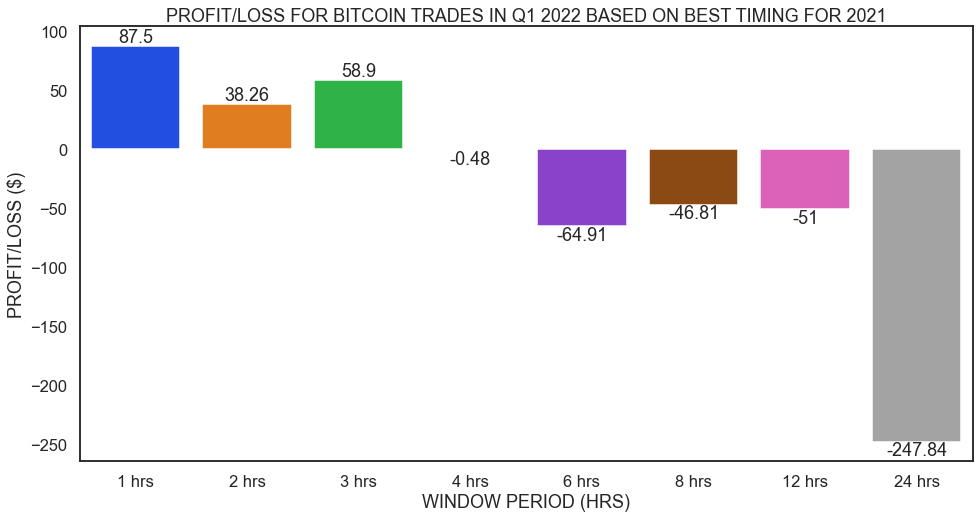

,profit_loss
window_period,
1 hrs,87.50
2 hrs,38.26
3 hrs,58.90
4 hrs,-0.48
6 hrs,-64.91
8 hrs,-46.81
12 hrs,-51.00
24 hrs,-247.84


In [154]:
daily_trade_df = pd.DataFrame(columns = ['window_period','profit_loss'])
best_hourly_patterns = {
    1:best_hourly_pattern,
    2:best_hourly2_pattern,
    3:best_hourly3_pattern,
    4:best_hourly4_pattern,
    6:best_hourly6_pattern,
    8:best_hourly8_pattern,
    12:best_hourly12_pattern,
    24:best_hourly24_pattern,
    48:best_hourly48_pattern
}
for window_period in [1,2,3,4,6,8,12,24]:    
    daily_trade = {'window_period' : f'{window_period} hrs', 
                  'profit_loss' : get_test_profit_loss(test_df.copy(), 
                                                       window_period, 
                                                       best_hourly_patterns[window_period], 
                                                       min_percent = 55)}

    daily_trade_df=daily_trade_df.append(daily_trade,ignore_index=True)
    
daily_trade_df.set_index('window_period',inplace=True)

plot_data_bar(daily_trade_df,'profit_loss',
              'PROFIT/LOSS FOR BITCOIN TRADES IN Q1 2022 BASED ON BEST TIMING FOR 2021','WINDOW PERIOD (HRS)','PROFIT/LOSS ($)','bright', show_yvalue = True)
    
    
display(daily_trade_df)


In [ ]:
test_df

# TEMP

In [ ]:
test_df.reset_index(inplace=True)
BEST_HOURLY_DF['hour'] = BEST_HOURLY_DF['hours'].str.split(':',n=-1, expand=True)[0]
BEST_HOURLY_DF['hour'] = BEST_HOURLY_DF['hour'].astype(int)
#test_filtered_df = BEST_HOURLY_DF.merge(test_df, on=['day','hour'], how='inner')

test_filtered_df = pd.merge(BEST_HOURLY_DF, test_df, on=['day','hour'], how='left')
test_filtered_df.dropna(inplace=True)

test_filtered_df[test_filtered_df['profit_or_loss'] == 'GREEN']




test_filtered_df['qty'] = INVESTMENT_AMOUNT_DOLLARS/test_filtered_df['open']
test_filtered_df['profit_loss'] = test_filtered_df['qty'] * test_filtered_df['window_price'] - INVESTMENT_AMOUNT_DOLLARS
profit_loss = round(test_filtered_df['profit_loss'].sum(),2)
print(f"profit/loss:{profit_loss}$ --> {round(profit_loss/INVESTMENT_AMOUNT_DOLLARS*100,2)}%")
display(test_filtered_df[['actual_date','hours','day','hour','open','window_price','qty','profit_loss']])




### HOURLY PATTERNS BY DAY

In [ ]:
hourly_pattern = get_pattern_for_window(btc_1h,  groupbyday = True, window_period = 1)
print("HOURLY PATTERN")
display(hourly_pattern.head(3))

hourly2_pattern = get_pattern_for_window(btc_1h, groupbyday = True, window_period = 2)
print("TWO HOURS PATTERN")
display(hourly2_pattern.head(3))

hourly3_pattern = get_pattern_for_window(btc_1h, groupbyday = True, window_period = 3)
print("THREE HOURS PATTERN")
display(hourly3_pattern.head())


hourly4_pattern = get_pattern_for_window(btc_1h, groupbyday = True, window_period = 4)
print("FOUR HOURS PATTERN")
display(hourly4_pattern.head())


hourly6_pattern = get_pattern_for_window(btc_1h, groupbyday = True, window_period = 6)
print("SIX HOURS PATTERN")
display(hourly6_pattern.head())


hourly8_pattern = get_pattern_for_window(btc_1h, groupbyday = True, window_period = 8)
print("EIGHT HOURS PATTERN")
display(hourly8_pattern.head())


hourly12_pattern = get_pattern_for_window(btc_1h, groupbyday = True, window_period = 12)
print("TWELVE HOURS PATTERN")
display(hourly12_pattern.head())


hourly24_pattern = get_pattern_for_window(btc_1h, groupbyday = True, window_period = 24)
print("TWENTY-FOUR HOURS PATTERN")
display(hourly24_pattern.head())


### HOURLY PATTERNS

In [ ]:
hourly_pattern = get_pattern_for_window(btc_1h,  groupbyday = False, window_period = 1)
print("HOURLY PATTERN")
display(hourly_pattern.head(3))

hourly2_pattern = get_pattern_for_window(btc_1h, groupbyday = False, window_period = 2)
print("TWO HOURS PATTERN")
display(hourly2_pattern.head(3))

hourly3_pattern = get_pattern_for_window(btc_1h, groupbyday = False, window_period = 3)
print("THREE HOURS PATTERN")
display(hourly3_pattern.head())


hourly4_pattern = get_pattern_for_window(btc_1h, groupbyday = False, window_period = 4)
print("FOUR HOURS PATTERN")
display(hourly4_pattern.head())


hourly6_pattern = get_pattern_for_window(btc_1h, groupbyday = False, window_period = 6)
print("SIX HOURS PATTERN")
display(hourly6_pattern.head())


hourly8_pattern = get_pattern_for_window(btc_1h, groupbyday = False, window_period = 8)
print("EIGHT HOURS PATTERN")
display(hourly8_pattern.head())


hourly12_pattern = get_pattern_for_window(btc_1h, groupbyday = False, window_period = 12)
print("TWELVE HOURS PATTERN")
display(hourly12_pattern.head())


hourly24_pattern = get_pattern_for_window(btc_1h, groupbyday = False, window_period = 24)
print("TWENTY-FOUR HOURS PATTERN")
display(hourly24_pattern.head())


### IDENTIFY THE BEST TRADING WINDOWS

In [ ]:
def trading_window_pattern(hourly_pattern_df, window_size, close_col):
    pattern_df = hourly_pattern_df[hourly_pattern_df['hour'] % window_size == 0].sort_values(by = ['hour', close_col])
    pattern_df['window'] = pattern_df['hour'].apply(lambda x:  f'{x}-{x+window_size}')
    
    return pattern_df[['window', close_col,'percent']]

In [ ]:
trading_window_pattern(hourly4_pattern, window_size = 4, close_col = 'next4_opened')

In [ ]:
trading_window_pattern(hourly3_pattern, window_size = 3, close_col = 'next3_opened')

In [ ]:
trading_window_pattern(hourly2_pattern, window_size = 2, close_col = 'next2_opened')

In [ ]:
trading_window_pattern(hourly6_pattern, window_size = 6, close_col = 'next6_opened')

In [ ]:
trading_window_pattern(hourly12_pattern, window_size = 12, close_col = 'next12_opened')

In [ ]:
# TEST

### TODO  - BEGIN

In [ ]:
# test_hourly2_pattern = get_pattern_for_window(btc_1h, groupbyday = True, window_period = 2)


# def plot_best_time_window(best_window_df, title_string):
    
#     f, ax = plt.subplots(figsize=(16,10))
#     #limegreen,lightseagreen,darkgreen, seagreen,forestgreen, mediumseagreen
#     # https://medium.com/@andykashyap/top-5-tricks-to-make-plots-look-better-9f6e687c1e08
#     hue_colors = {'RED': "red", 'GREEN': "forestgreen"}
#     ax = sns.barplot(x="day", y="percent", hue="profit_or_loss", data=best_window_df,palette = hue_colors)
#     ax.set( xlabel='Day',ylabel='Percentage',title = f'BEST TIME TO TRADE - {title_string}')
#     plt.legend(title = "Profit/Loss")
#     plt.ylim(ymax = 100, ymin = 0)
#     #plt.legend().remove()

#     for i, p in enumerate(ax.patches):
#         ax.text(p.get_x()+p.get_width()/2., p.get_height() + 1, 
#                 f"{int(best_window_df.iloc[i]['percent'])}%",ha="center")
#         ax.text(p.get_x()+p.get_width()/2., p.get_height() + 8, 
#                 f"{best_window_df.iloc[i]['hours']}",ha="center", rotation=90)
 
#     plt.show()
     

# def display_window_pattern(pattern_df, pattern_string):
#     best_window_df = pattern_df.sort_values(['percent','profit_or_loss'], ascending=False).drop_duplicates(['day','profit_or_loss'])
#     plot_best_time_window(best_window_df,pattern_string)
    
    
# display_window_pattern(test_hourly2_pattern,"TWO HOURS WINDOW")

### TODO  - END